In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

## Creation of the matrix (just load, last line)

In [12]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')
history = pd.read_csv('data/order_products__prior.csv', sep=',')

In [3]:
orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history[["order_id","product_id"]].sort_values(by='order_id')#.head(1000000)

In [ ]:
consumptions = pd.merge(history_small, orders_small, on="order_id")[['user_id','product_id']]

In [ ]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

In [ ]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

In [ ]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

In [ ]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

In [ ]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

In [ ]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [ ]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

In [64]:
user_matrix = pd.read_pickle('matrix.p') #Load directly the matrix
user_matrix = user_matrix[1:] #first row is empty

## Determine the optimal k

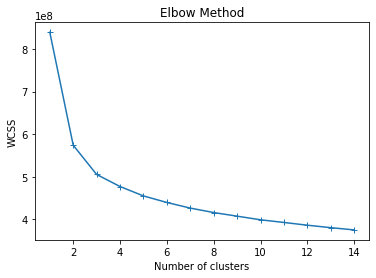

In [3]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(user_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss,marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method : the optimal number is k=3

Verification with silhouette methode :

In [13]:
#NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s1 = silhouette_score(user_matrix, labels)
#s1

0.6710904937285531

In [14]:
# NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s2 = silhouette_score(user_matrix, labels)
#s2

0.5245359402930275

Silhouette method actually gives 2

## Cluster sizes

In [61]:
def get_cluster_size(clustering, nb_clusters,matrix=user_matrix) :
    for k in range(nb_clusters):
        number_users_in_cluster = 0.
        for user_index in range(1,len(matrix)) :
            if kmeans.labels_[user_index]==k :
                number_users_in_cluster+=1
        print(number_users_in_cluster)

In [7]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 2)

186943.0
19265.0


In [8]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 3)

167141.0
32179.0
6888.0


Clusters are very inequal, this clustering is not relevant.

## Clustering avec contrainte sur clusters size

In [65]:
import constrained_kmeans as cons

In [ ]:
#ne pas run : tres tres long
(C,M,f) = cons.constrained_kmeans(user_matrix, [92794,92794], maxiter=50)

Way too long to run (more than 6hours), never finished

## Dimensionnality reduction

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [66]:
user_matrix = np.array(user_matrix)

In [67]:
row_sums = user_matrix.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = user_matrix / row_sums[:, np.newaxis]

In [11]:
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [12]:
reduc_matrix = pca.transform(user_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

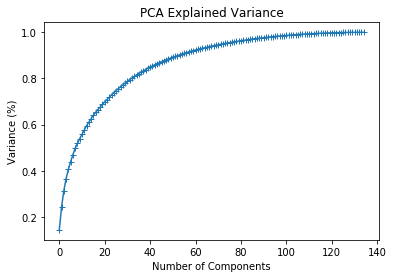

In [13]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

dimension choosen at the elbow : dim=30

In [68]:
pca = PCA(n_components=30, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

In [15]:
reduc_matrix.shape

(206209, 30)

Determine the right number of clusters (k)

In [ ]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal k is 5 with this method

In [69]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(reduc_matrix)

In [70]:
get_cluster_size(kmeans, 5, reduc_matrix)

38233.0
55661.0
7932.0
5366.0
99016.0


That's better : 3 pretty big clusters and 2 small (2 et 3)

## Analyse the clusters

**Look at centroids distance**

In [71]:
kmeans.cluster_centers_

array([[ 6.71504001e-02,  1.05080601e-01, -1.21770598e-03,
        -3.08570484e-02, -1.05411714e-02,  7.26897553e-03,
        -5.20583165e-04,  4.47131860e-03, -7.54747073e-04,
        -1.45952241e-04, -7.32296138e-04,  3.40642579e-05,
        -1.45034863e-03,  6.79077115e-04, -2.62330407e-04,
        -1.59982211e-04,  4.51228080e-04,  2.63687806e-04,
         3.61374268e-04,  5.99210042e-04,  3.12089635e-04,
        -4.04786463e-04,  1.98799717e-04,  2.55235581e-04,
         6.02676207e-04, -1.01206450e-04, -8.59671313e-05,
         3.43152540e-04, -2.10098292e-04,  9.35083882e-05],
       [ 1.05715927e-01, -7.33360176e-02,  1.73096174e-02,
         3.73793823e-03,  1.77693524e-03, -4.46848732e-03,
        -9.59793352e-04,  1.29292810e-03, -1.57508943e-04,
         7.91431212e-04,  1.29861761e-03,  1.10564280e-03,
         7.50951522e-04,  3.78520709e-04,  9.53589195e-04,
        -4.51014531e-04, -1.03737808e-04,  8.98614464e-04,
        -3.38762381e-04, -4.17722850e-04,  6.53295486e-

In [72]:
def dist_centroids(clustering):
    k=len(clustering.cluster_centers_)
    distances = np.zeros((k,k))
    for x in range(k):
        for y in range(x):
            dist = np.linalg.norm(clustering.cluster_centers_[x]-clustering.cluster_centers_[y]) #calculate euclidian distance
            distances[x,y]=dist
    return distances

In [73]:
dist_centroids(kmeans)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.18755526, 0.        , 0.        , 0.        , 0.        ],
       [0.30017687, 0.34356591, 0.        , 0.        , 0.        ],
       [0.42653041, 0.43958819, 0.4761357 , 0.        , 0.        ],
       [0.18624965, 0.19612675, 0.3105995 , 0.3704018 , 0.        ]])

cluster 2 and 3 are pretty 'basic' : look to all others, and are alike. Probably has something to do with the fact they are the two small clusters.

**prepare df**

In [7]:
aisles = pd.read_csv('data/aisles.csv', sep=',')

In [8]:
#convert the matrix into df
matrix_df = pd.DataFrame(user_matrix, index = range(len(user_matrix)), columns = ['Null']+list(aisles.aisle) )
matrix_df = matrix_df.drop('Null', axis=1) #drop first useless column
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Add a column 'cluster'
matrix_df['cluster']=kmeans.labels_
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
#Convert Normalized matrix into a df
norm_matrix_df = pd.DataFrame(norm_matrix, index = range(len(norm_matrix)), columns = ['Null']+list(aisles.aisle) )
norm_matrix_df = norm_matrix_df.drop('Null', axis=1) #drop first useless column
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.005128,0.0,0.030769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.055556
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [11]:
#Add column 'cluster'
norm_matrix_df['cluster']=kmeans.labels_
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4
1,0.005128,0.0,0.030769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0
2,0.000000,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.055556,4
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1


**Study the mean repartition of products per ailse in each clusters**

In [55]:
mean_clusters = norm_matrix_df.groupby(['cluster']).mean()
mean_clusters

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.002626,0.002323,0.012865,0.004271,0.001138,0.000945,0.000785,0.001214,0.005298,0.000193,...,0.001251,0.000337,0.000553,0.004380,0.004436,0.004763,0.005874,0.000113,0.000482,0.000170
1,0.001635,0.002933,0.007811,0.004021,0.002122,0.000928,0.001297,0.000688,0.007335,0.000297,...,0.000328,0.000349,0.000450,0.005712,0.003614,0.004043,0.009116,0.000135,0.000310,0.000166
2,0.002437,0.001125,0.003834,0.001141,0.000431,0.000429,0.002486,0.002222,0.001826,0.000707,...,0.003229,0.000000,0.000814,0.001196,0.001192,0.001685,0.000763,0.000046,0.001504,0.000707
3,0.001277,0.001079,0.013829,0.001724,0.000486,0.001228,0.000675,0.001318,0.001338,0.000554,...,0.003322,0.000693,0.002538,0.001111,0.001352,0.002477,0.001707,0.000148,0.001797,0.000689
4,0.002743,0.002495,0.015161,0.008394,0.002436,0.001847,0.001093,0.001825,0.007002,0.000531,...,0.001983,0.001353,0.003069,0.006158,0.007776,0.005129,0.007976,0.000356,0.001309,0.001227


**Evaluate the features discrimining the clusters**

In [16]:
matrix_df.corr()['cluster'].sort_values(ascending=True)

cluster                       1.000000
soft drinks                   0.153559
paper goods                   0.136513
body lotions soap             0.136126
cleaning products             0.125984
                                ...   
poultry counter              -0.086046
fresh herbs                  -0.176744
packaged vegetables fruits   -0.197503
fresh vegetables             -0.277253
fresh fruits                 -0.311720
Name: cluster, Length: 135, dtype: float64

features influencing the most the cluster affiliation seem to be the 9 ones listed above 
_not convinced by the method_

In [34]:
array = norm_matrix_df.values
X = array[:,0:-1]
Y = array[:,-1]

In [50]:
scores = SelectKBest(chi2, k=20).fit(X, Y)

In [52]:
features = pd.DataFrame(index=norm_matrix_df.columns[:-1], data= scores.scores_, columns=["Score"]).sort_values("Score",ascending=False)
features.head(10)

,Score
packaged produce,36182.246946
water seltzer sparkling water,21547.167605
fresh vegetables,12607.893035
fresh fruits,8476.947723
soft drinks,1526.762953
fresh herbs,1209.352566
packaged vegetables fruits,1100.078211
frozen meals,644.995977
paper goods,561.429783
ice cream ice,522.070240


_better method_ most important features

In [53]:
imp_features = features.head(10).index

In [56]:
mean_clusters[imp_features]

,packaged produce,water seltzer sparkling water,fresh vegetables,fresh fruits,soft drinks,fresh herbs,packaged vegetables fruits,frozen meals,paper goods,ice cream ice
cluster,,,,,,,,,,
0,0.011045,0.021670,0.075563,0.228131,0.006999,0.008120,0.070707,0.008015,0.004468,0.012104
1,0.003952,0.017446,0.218774,0.111934,0.004512,0.022809,0.066753,0.006371,0.004489,0.011409
2,0.292983,0.025529,0.043707,0.147302,0.013028,0.000290,0.060935,0.006034,0.002088,0.004134
3,0.015740,0.390199,0.014466,0.041773,0.053002,0.001618,0.018640,0.005504,0.017362,0.011205
4,0.005359,0.026973,0.041975,0.052864,0.024125,0.005401,0.036271,0.019585,0.014133,0.024045


0 : bcp de fresh fruits ; peu de soft drinks

1 : tres peu de packaged ; bcp de fresh vegetables  ; peu de soft drinks ; bcp herbs

2 : bcp de packaged ; peu d'herbs ; peu ice cream

3 :  bcp de sparkling water ; peu de fresh fruits ; peu de pack veg fruits ; bcp paper

4 : tres peu de packaged ; peu de fresh fruits ; peu de pack veg fruits ; bcp frozen meals ; bcp paper ; plus ice cream

classification healthiness : 1>0 (bons)  >  (mauvais) 3>2>4